In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import os
import zipfile
import pandas as pd

# Specify the path to the ZIP file
zip_file_path = r"/content/drive/MyDrive/lung disease.zip"
# Specify the directory where you want to extract the contents
extracted_dir_path = r'C:\Users\karth\Downloads\lung_disease_extracted'

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Generate data paths with labels
filepaths = []
labels = []

# Iterate through the extracted directories
for root, dirs, files in os.walk(extracted_dir_path):
    for f in files:
        # Get the full file path
        fpath = os.path.join(root, f)
        filepaths.append(fpath)

        # Determine the label based on the directory name
        folder_name = os.path.basename(root)
        if folder_name == 'colon_aca':
            labels.append('Colon Adenocarcinoma')
        elif folder_name == 'colon_n':
            labels.append('Colon Benign Tissue')
        elif folder_name == 'lung_aca':
            labels.append('Lung Adenocarcinoma')
        elif folder_name == 'lung_n':
            labels.append('Lung Benign Tissue')
        elif folder_name == 'lung_scc':
            labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Optionally, you can clean up the extracted directory after you're done processing
# Note: Be cautious with this step, as it deletes the extracted files
# import shutil
# shutil.rmtree(extracted_dir_path)


In [ ]:
df

filepaths                labels
0      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
1      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
2      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
3      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
4      C:\Users\karth\Downloads\lung_disease_extracte...   Lung Adenocarcinoma
...                                                  ...                   ...
24974  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24975  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24976  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24977  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma
24978  C:\Users\karth\Downloads\lung_disease_extracte...  Colon Adenocarcinoma

[24979 rows x 2 columns]

In [ ]:
#Split data into train, valid, and test

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
#Create image data generator

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 19983 validated image filenames belonging to 5 classes.
Found 2997 validated image filenames belonging to 5 classes.
Found 1999 validated image filenames belonging to 5 classes.


In [ ]:
#Show sample from train data

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
#Model Structure
#Generic Model Creation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB3

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Assuming train_gen is your image generator

# Create pre-trained model
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Freeze base model layers
base_model.trainable = False

# Build the complete model
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dropout(rate=0.5),  # Adjust dropout rate as needed
    Dense(class_count, activation='softmax')
])

# Compile the model with Adamax optimizer
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                         

In [ ]:
#Train model

In [ ]:
epochs = 12   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/12
1249/1249 [==============================] - 154s 110ms/step - loss: 0.2950 - accuracy: 0.8974 - val_loss: 0.0668 - val_accuracy: 0.9726
Epoch 2/12
1249/1249 [==============================] - 133s 106ms/step - loss: 0.1543 - accuracy: 0.9440 - val_loss: 0.0472 - val_accuracy: 0.9823
Epoch 3/12
1249/1249 [==============================] - 120s 96ms/step - loss: 0.1206 - accuracy: 0.9557 - val_loss: 0.0402 - val_accuracy: 0.9850
Epoch 4/12
1249/1249 [==============================] - 127s 102ms/step - loss: 0.1115 - accuracy: 0.9606 - val_loss: 0.0309 - val_accuracy: 0.9907
Epoch 5/12
1249/1249 [==============================] - 129s 104ms/step - loss: 0.0980 - accuracy: 0.9664 - val_loss: 0.0277 - val_accuracy: 0.9907
Epoch 6/12
1249/1249 [==============================] - 128s 102ms/step - loss: 0.0853 - accuracy: 0.9681 - val_loss: 0.0258 - val_accuracy: 0.9917
Epoch 7/12
1249/1249 [==============================] - 128s 103ms/step - loss: 0.0800 - accuracy: 0.9708 - val_l

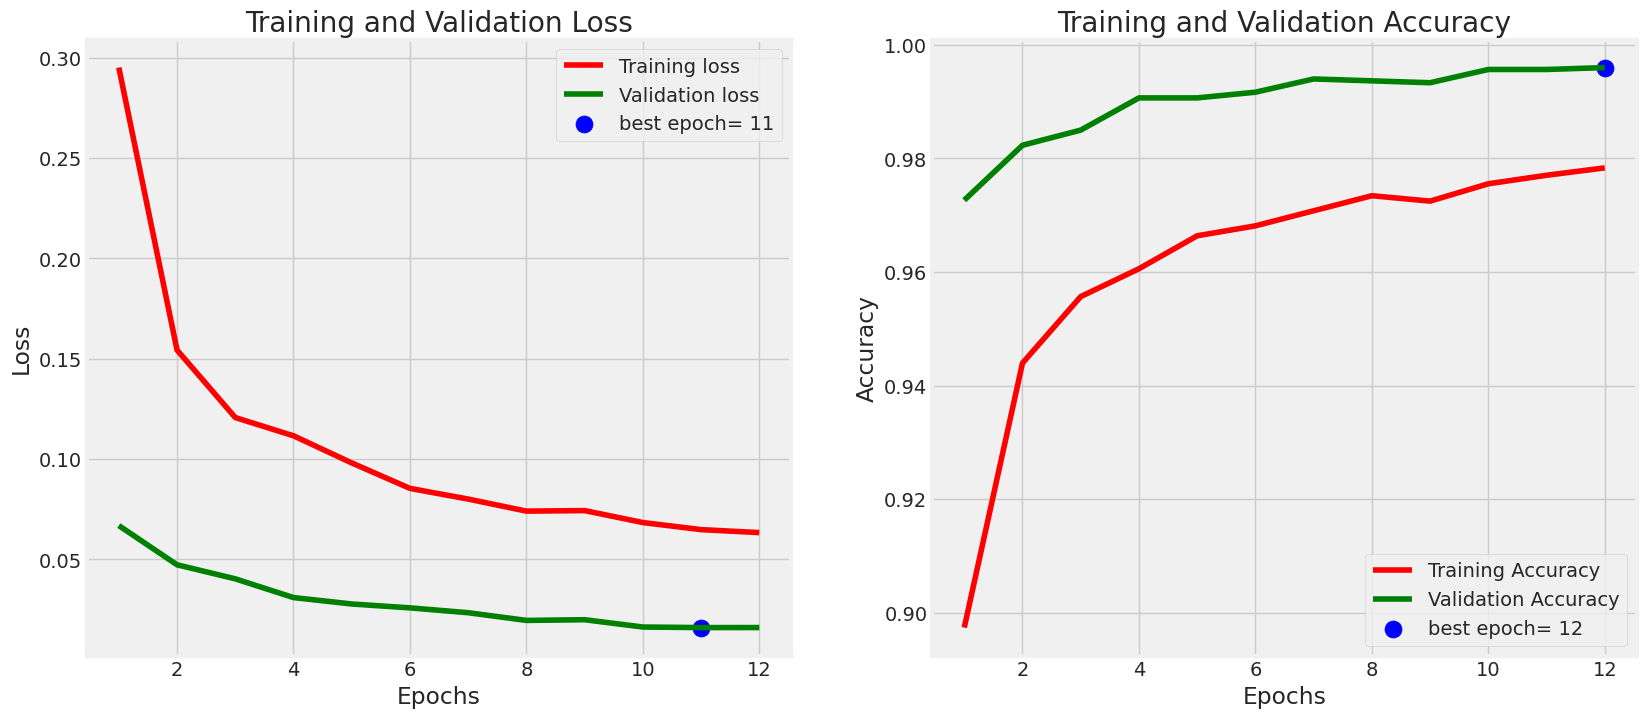

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1249/1999 [=================>............] - ETA: 1:05 - loss: 0.0078 - accuracy: 0.9990

 187/1999 [=>............................] - ETA: 2:36 - loss: 0.0160 - accuracy: 0.9960

 125/1999 [>.............................] - ETA: 2:53 - loss: 0.0171 - accuracy: 0.9955

1999/1999 [==============================] - 12s 6ms/step - loss: 0.0171 - accuracy: 0.9955
Train Loss:  0.007807934656739235
Train Accuracy:  0.999049186706543
--------------------
Validation Loss:  0.01597096398472786
Validation Accuracy:  0.9959959983825684
--------------------
Test Loss:  0.01705232262611389
Test Accuracy:  0.9954977631568909


In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

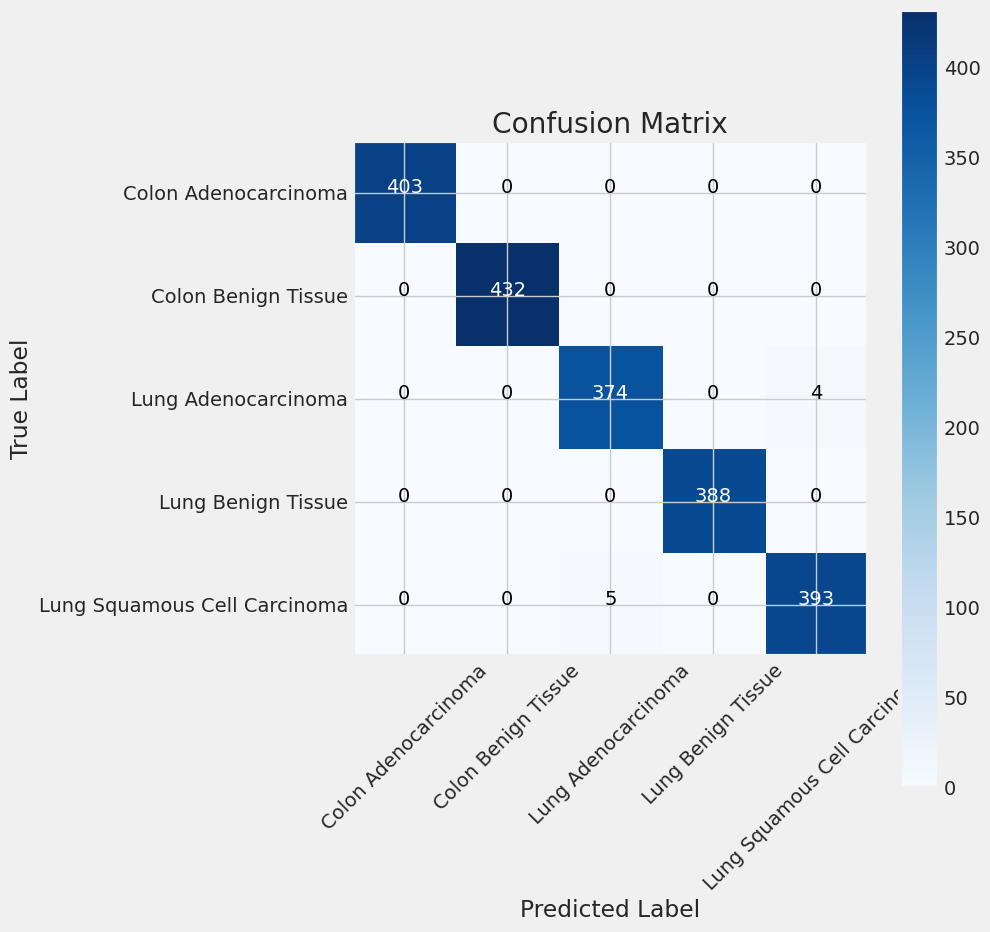

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       403
         Colon Benign Tissue       1.00      1.00      1.00       432
         Lung Adenocarcinoma       0.99      0.99      0.99       378
          Lung Benign Tissue       1.00      1.00      1.00       388
Lung Squamous Cell Carcinoma       0.99      0.99      0.99       398

                    accuracy                           1.00      1999
                   macro avg       1.00      1.00      1.00      1999
                weighted avg       1.00      1.00      1.00      1999



In [ ]:
#Save the model
model.save('/content/drive/MyDrive/EfficientNetB3_model_mod_param.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/EfficientNetB3_model_mod_param.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/colonn15.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 5s 5s/step
Colon Benign Tissue


In [ ]:
predictions

array([[1.5199703e-07, 9.9999988e-01, 3.2414746e-09, 9.5840011e-12,
        4.9765025e-10]], dtype=float32)

In [ ]:
print(score)

tf.Tensor([0.14884761 0.40460962 0.1488476  0.1488476  0.1488476 ], shape=(5,), dtype=float32)


In [ ]:
image_path = '/content/COLON1.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 57ms/step
Colon Adenocarcinoma


In [ ]:
predictions

array([[9.1215032e-01, 7.0813149e-07, 1.5880685e-06, 3.4955968e-07,
        8.7846927e-02]], dtype=float32)

In [ ]:
print(score)

tf.Tensor([0.37828344 0.1519413  0.15194143 0.15194124 0.16589257], shape=(5,), dtype=float32)


In [ ]:
image_path = '/content/colon_aca_google.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 57ms/step
Colon Adenocarcinoma


In [ ]:
image_path = '/content/LUNG1.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 63ms/step
Colon Adenocarcinoma


In [ ]:
image_path = '/content/lungscc4860.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 59ms/step
Lung Squamous Cell Carcinoma


EfficientNetB3 different parameter

2nd model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB3

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Assuming train_gen is your image generator

# Create pre-trained model
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Freeze base model layers
base_model.trainable = False

# Build the complete model with modified hyperparameters and activation functions
model1 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(rate=0.4),  # Adjust dropout rate as needed
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(rate=0.3),  # Adjust dropout rate as needed
    Dense(class_count, activation='softmax')
])

# Compile the model with Adamax optimizer
model1.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)              

In [ ]:
#Train model

In [ ]:
epochs = 12   # number of all epochs in training

history = model1.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/12
1249/1249 [==============================] - 151s 111ms/step - loss: 5.7345 - accuracy: 0.9004 - val_loss: 2.1745 - val_accuracy: 0.9716
Epoch 2/12
1249/1249 [==============================] - 136s 109ms/step - loss: 1.1805 - accuracy: 0.9402 - val_loss: 0.5274 - val_accuracy: 0.9710
Epoch 3/12
1249/1249 [==============================] - 130s 104ms/step - loss: 0.4466 - accuracy: 0.9446 - val_loss: 0.2873 - val_accuracy: 0.9723
Epoch 4/12
1249/1249 [==============================] - 130s 104ms/step - loss: 0.3338 - accuracy: 0.9456 - val_loss: 0.2455 - val_accuracy: 0.9700
Epoch 5/12
1249/1249 [==============================] - 129s 103ms/step - loss: 0.2970 - accuracy: 0.9477 - val_loss: 0.2155 - val_accuracy: 0.9726
Epoch 6/12
1249/1249 [==============================] - 129s 103ms/step - loss: 0.2802 - accuracy: 0.9499 - val_loss: 0.2083 - val_accuracy: 0.9750
Epoch 7/12
1249/1249 [==============================] - 135s 108ms/step - loss: 0.2752 - accuracy: 0.9514 - val_

In [ ]:
#Display model performance

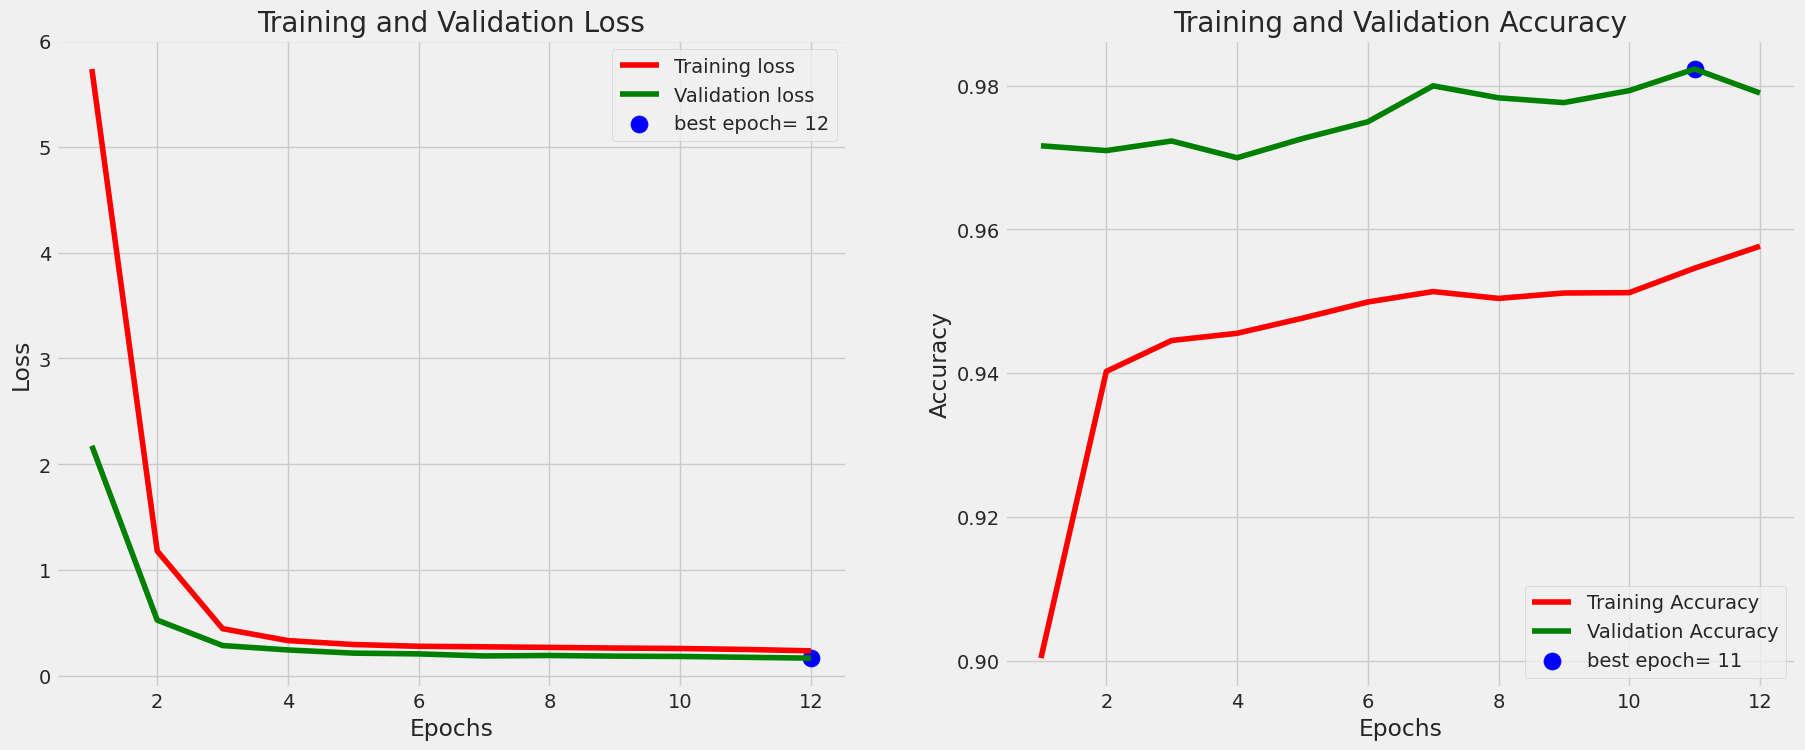

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model1.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model1.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model1.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1249/1999 [=================>............] - ETA: 1:10 - loss: 0.0078 - accuracy: 0.9990

 187/1999 [=>............................] - ETA: 2:42 - loss: 0.0160 - accuracy: 0.9960

 125/1999 [>.............................] - ETA: 2:49 - loss: 0.0171 - accuracy: 0.9955

1999/1999 [==============================] - 11s 6ms/step - loss: 0.0171 - accuracy: 0.9955
Train Loss:  0.00780793372541666
Train Accuracy:  0.999049186706543
--------------------
Validation Loss:  0.01597096025943756
Validation Accuracy:  0.9959959983825684
--------------------
Test Loss:  0.01705232262611389
Test Accuracy:  0.9954977631568909


In [ ]:
preds = model1.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

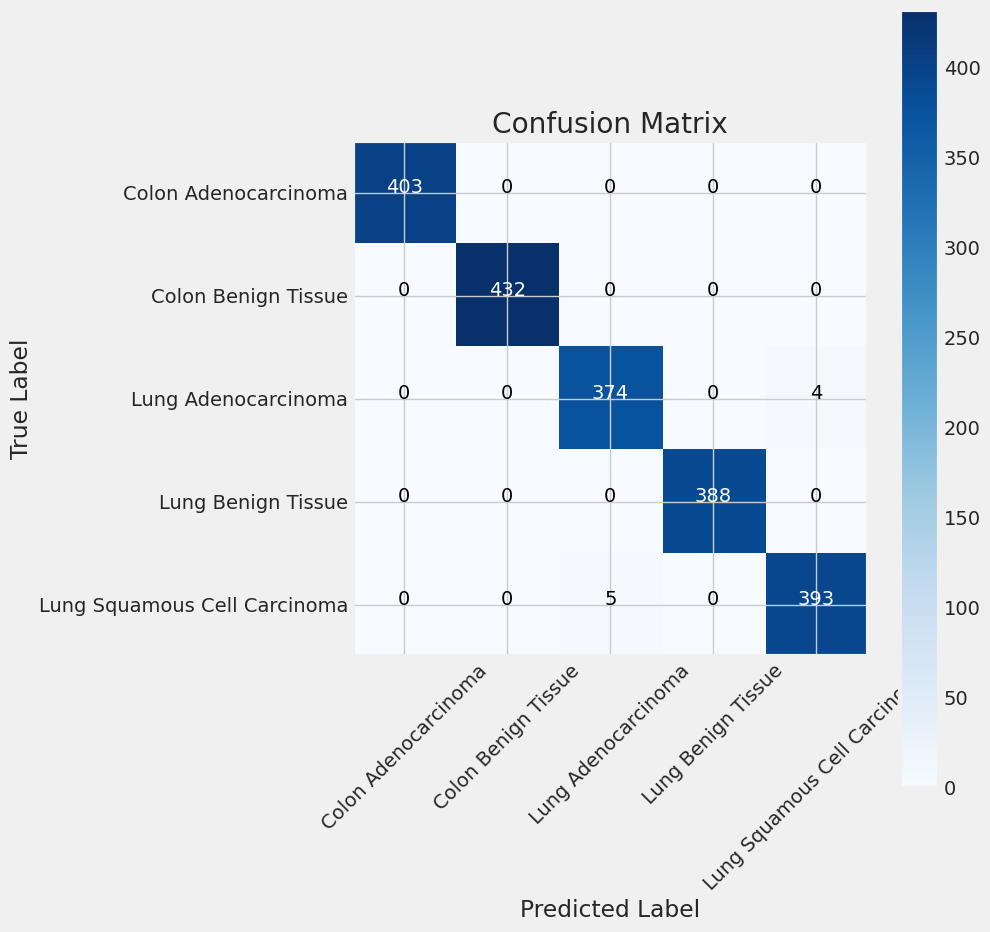

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       403
         Colon Benign Tissue       1.00      1.00      1.00       432
         Lung Adenocarcinoma       0.99      0.99      0.99       378
          Lung Benign Tissue       1.00      1.00      1.00       388
Lung Squamous Cell Carcinoma       0.99      0.99      0.99       398

                    accuracy                           1.00      1999
                   macro avg       1.00      1.00      1.00      1999
                weighted avg       1.00      1.00      1.00      1999



In [ ]:
#Save the model
model.save('/content/drive/MyDrive/EfficientNetB3_model_mod_param_1.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/EfficientNetB3_model_mod_param_1.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/COLON.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 6s 6s/step
Lung Squamous Cell Carcinoma


In [ ]:
predictions

array([[1.2301990e-04, 4.4132748e-01, 2.7224229e-05, 7.7670666e-05,
        5.5844462e-01]], dtype=float32)

In [ ]:
image_path = '/content/LUNG.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 420ms/step
Lung Squamous Cell Carcinoma


In [ ]:
predictions

array([[5.9857383e-02, 4.3353311e-06, 2.1232823e-02, 3.4580975e-05,
        9.1887093e-01]], dtype=float32)

In [ ]:
image_path = '/content/colonca5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 156ms/step
Colon Adenocarcinoma


In [ ]:
predictions

array([[9.9999976e-01, 7.8392376e-10, 1.0693958e-09, 7.5029035e-13,
        1.9801172e-07]], dtype=float32)

In [ ]:
image_path = '/content/colonn5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 163ms/step
Colon Benign Tissue


In [ ]:
predictions

array([[2.2919674e-15, 1.0000000e+00, 1.3563984e-14, 2.7299398e-16,
        5.2732246e-14]], dtype=float32)

In [ ]:
image_path = '/content/lungaca5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 243ms/step
Lung Adenocarcinoma


In [ ]:
predictions

array([[2.3583778e-05, 2.1195674e-05, 9.9965441e-01, 6.2600591e-08,
        3.0071006e-04]], dtype=float32)

In [ ]:
image_path = '/content/lungn5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 174ms/step
Lung Benign Tissue


In [ ]:
predictions

array([[2.7246843e-08, 1.2182096e-09, 7.9691824e-07, 9.9999917e-01,
        8.6296720e-10]], dtype=float32)

In [ ]:
image_path = '/content/lungscc5000.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 298ms/step
Lung Squamous Cell Carcinoma


In [ ]:
predictions

array([[2.8055754e-06, 1.3379764e-07, 5.9007728e-03, 1.8177702e-06,
        9.9409455e-01]], dtype=float32)

In [ ]:
print(score)

tf.Tensor([0.33240223 0.15659302 0.17975867 0.15675823 0.1744878 ], shape=(5,), dtype=float32)


In [ ]:
image_path = '/content/LUNG1.png'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")